NLP is a very hot topic at the moment and as believed by many experts '2020 is going to be NLP's Year'. With it's ever changing dynamics,  NLP is experiencing a boom , same as computer vision once did. Due to its popularity Kaggle launched two NLP competitions recently and me being a lover of NLP and wanted to enhance my skill with it, I decided to join this competition. 

In this Notebook I will cover the following Deep Learning models :

- Simple RNN's
- LSTM's
- GRU's
- BI-Directional RNN's

I will also talk about *seq2seq*, *Attention models* and *BERT*. 

Note that the aim of this notebook is not to obtained the highest score, I haven't the right computer for this nor the time. Instead, I want to fully undertand  Deep Learning techniques used for NLP.

So here's the "Jigsaw Multilingual Toxic Comment Classification" competition! I already participated on "Jigsaw Toxic Comment Classification"  on Kaggle, my notebook is on GitHub and Linkedin if you want to take a look.
Like is predecessor, in this competition, contestants are challenged to build machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion. This problem matters because one toxic comment is enough to sour an online discussion. By identifying and filtering toxic comments online, we can have a safer, more collaborative internet, leading to greater productivity and happiness. And that's very important.

In this kernel, I will explore the data. Then, I will explain and demonstrate how various deep learning models can be used to identify toxic comments with tensorflow.keras.

1. [Import packages](#1)
1. [Load data](#2)
1. [Data Exploration](#3)
    - Workcloud for all the comments in train
    - Number of words present in the comments.
    - WorkCloud for toxic comments
    - WorkCloud for clean comments
    - WorkCloud for Obscene/Severe Toxic/Threat/Insult comments
1. [Modeling](#4)
1. [Text preprocessing](#4)
1. [Logistic Regression](#13)
    - Basic Preprocessing
    - Model
    - Performances
    - Model inteprretation with LIME
1. [SIMPLE RNN](#6)
    - Basic Overview : What is a RNN?
    - tokenizer and padding
    - Designing RNN Architecture
    - Model's performances
    - Saving our model
1. [LSTM's](#7)
    - Basic Overview
    - Word Embedding
    - Designing LSTM Architecture
    - Model's performances
1. [GRU's](#9)
    - Basic Overview
    - Designing GRU Architecture
    - Model's performances
1. [Bi-Directional RNN's](#10)
    - Designing GRU Architecture
    - Model's performances
1. [Bi-Directional RNN's](#14)
1. [Conclusion](#11)
1. [One step further with seq2seq/Attention/BERT](#12)

<a id="1"></a> <br>
## Import packages

In [2]:
import pickle
import time

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns


from wordcloud import WordCloud, STOPWORDS

stopword=set(STOPWORDS)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


<a id="2"></a> <br>
## Load data

In [37]:
val = pd.read_csv("validation.csv")
test = pd.read_csv('test.csv')
train = pd.read_csv("jigsaw-toxic-comment-train.csv")

In [7]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 136.0 MB


In [10]:
for dtype in ['int64','object']:
    selected_dtype = train.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for int64 columns: 1.46 MB
Average memory usage for object columns: 41.92 MB


In [7]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
val.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [5]:
test.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


<a id="3"></a> <br>
## Data exploration

**Workcloud for all the comments in train**

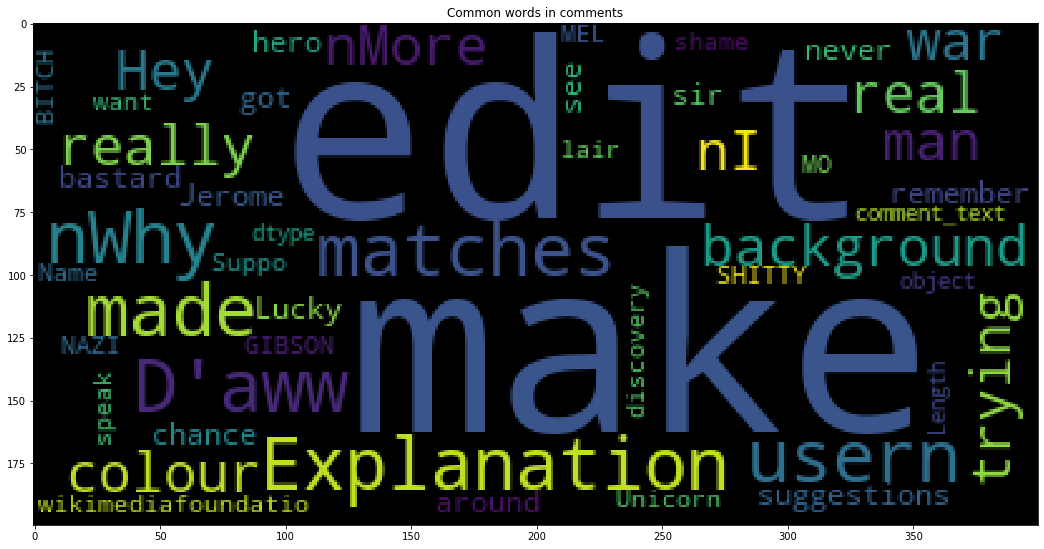

In [8]:
wc = WordCloud(stopwords=stopword)
plt.figure(figsize=(18,10))
wc.generate(str(train['comment_text']))
plt.imshow(wc)
plt.title('Common words in comments');

In the wordcloud above, we can see the most common words in the comments. These words include "edit", "Explanation", and "background" among other words. More offensive words like "Bastard" and "Nazi" seem to occur less often, indicating that toxic, insulting comments are seen less frequently than non-toxic comments.

**Comment words **

Now, I will look at the number of words present in the comments.

Distribution of comment words

In [5]:
def new_len(x):
    if type(x) is str:
        return len(x.split())
    else:
        return 0

train["comment_words"] = train["comment_text"].apply(new_len)

From the plot above, we can see that the distribution of comment words has a strong rightward (positive) skew with maximum probability denisty occuring at around 13 words. As the number of words increases beyond 13, the frequency reduces sharply.

Targets 
Now, I will visualize the targets in the dataset.

**Wordclouds for different categories**

Non-toxic vs. Toxic

In [22]:
Toxic = train[train['toxic'] == 1]
NoToxic = train[train['toxic'] == 0]

**WorkCloud for toxic comments**

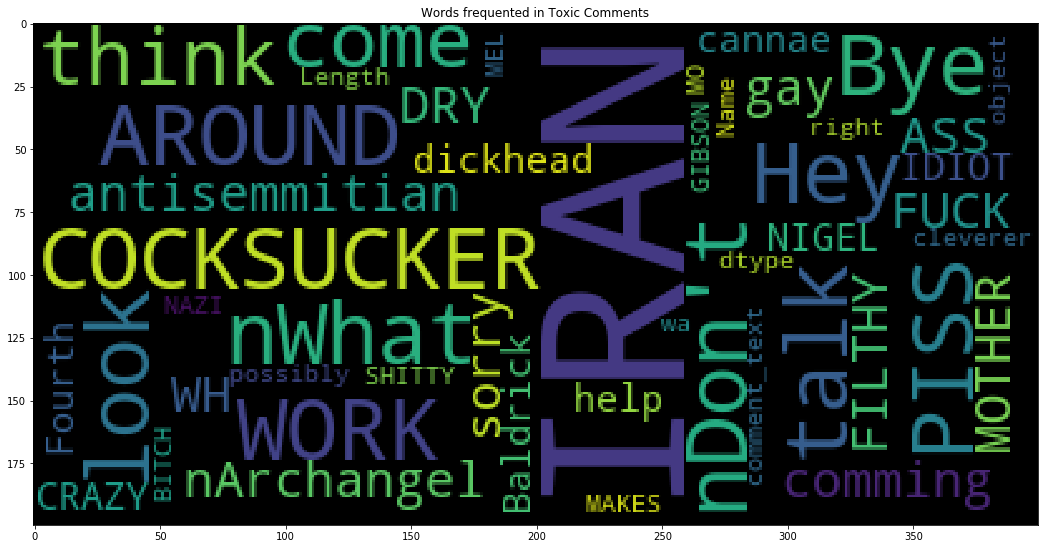

In [24]:
wc = WordCloud(stopwords= stopword)
plt.figure(figsize = (18,12))
wc.generate(str(Toxic['comment_text']))
plt.imshow(wc)
plt.title('Words frequented in Toxic Comments');

**WorkCloud for clean comments**

Text(0.5, 1.0, 'Words frequented in Clean Comments')

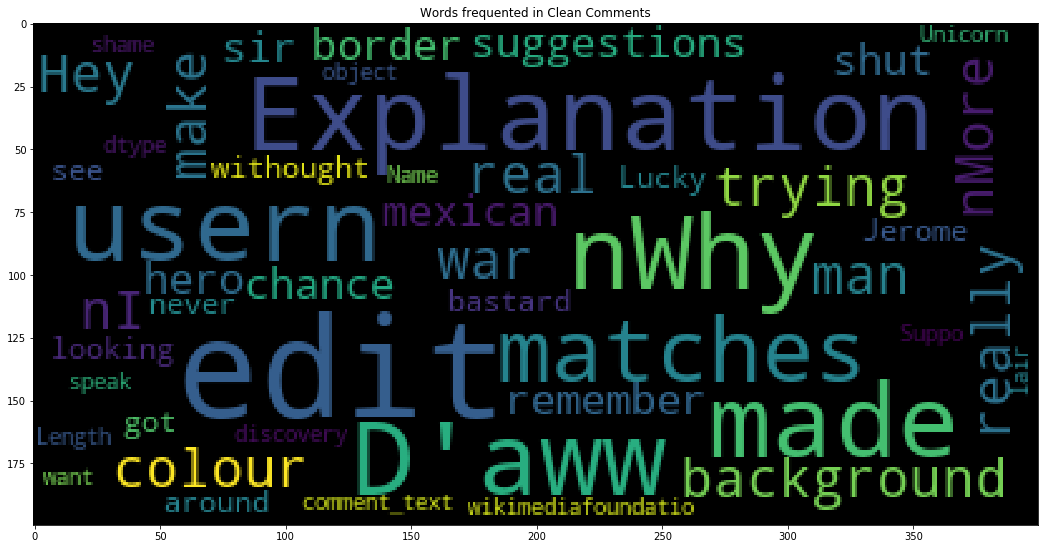

In [27]:
wc = WordCloud(stopwords= stopword)
plt.figure(figsize = (18,12))
wc.generate(str(NoToxic['comment_text']))
plt.imshow(wc)
plt.title('Words frequented in Clean Comments')

We can see from the above wordclouds, that toxic comments use more insluting or hateful words such as "f**k" or "idiot", while the non-toxic comments do not usually use such words.

**WorkCloud for Obscene/Severe Toxic/Threat/Insult comments**

In [28]:
obscene = train[train['obscene'] == 1]
severe = train[train['severe_toxic'] == 1]
threat = train[train.threat == 1]
insult = train[train.insult == 1]

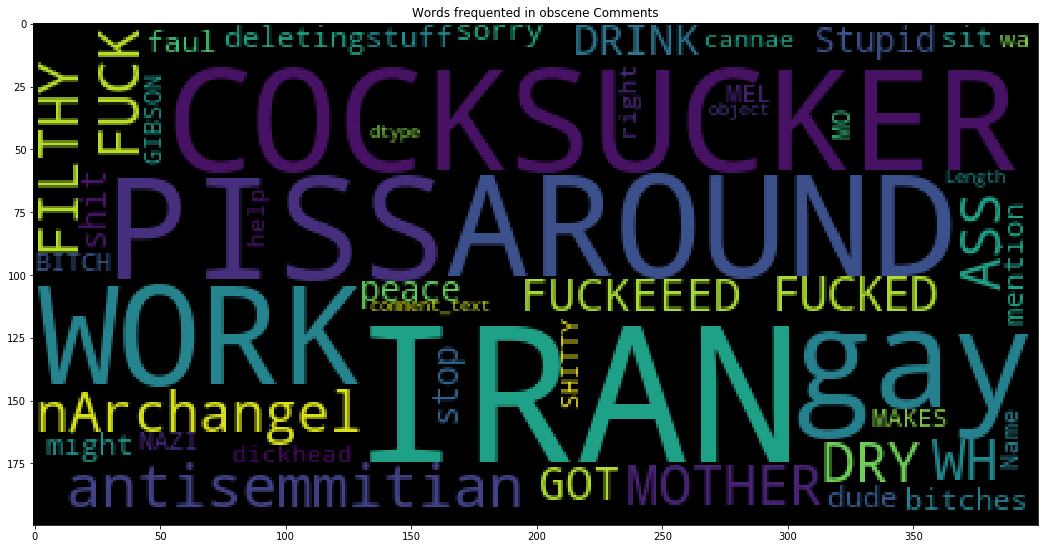

In [30]:
wc = WordCloud(stopwords= stopword)
plt.figure(figsize = (18,12))
wc.generate(str(obscene['comment_text']))
plt.imshow(wc)
plt.title('Words frequented in obscene Comments');

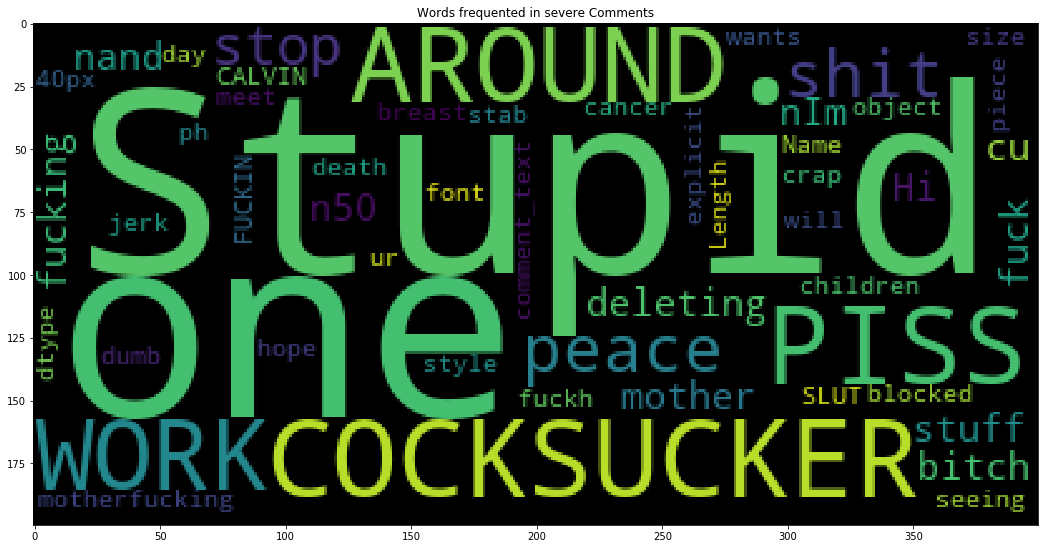

In [32]:
wc = WordCloud(stopwords= stopword)
plt.figure(figsize = (18,12))
wc.generate(str(severe['comment_text']))
plt.imshow(wc)
plt.title('Words frequented in severe Comments');

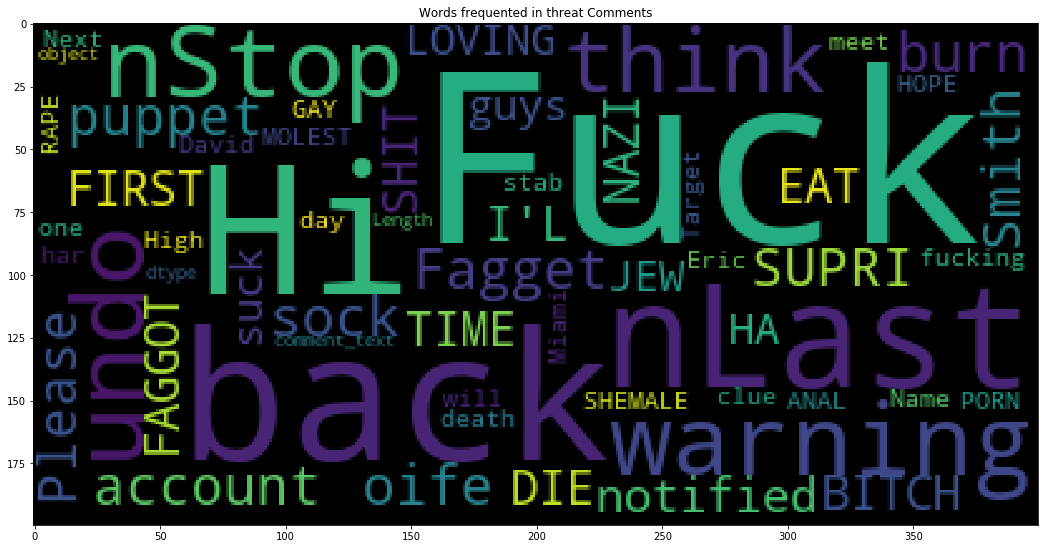

In [33]:
wc = WordCloud(stopwords= stopword)
plt.figure(figsize = (18,12))
wc.generate(str(threat['comment_text']))
plt.imshow(wc)
plt.title('Words frequented in threat Comments');

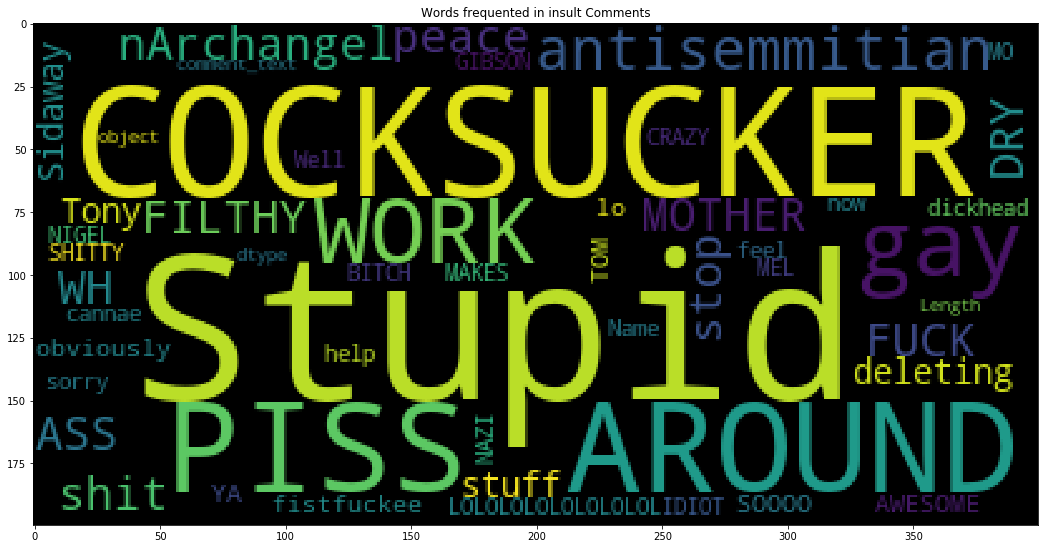

In [34]:
wc = WordCloud(stopwords= stopword)
plt.figure(figsize = (18,12))
wc.generate(str(insult['comment_text']))
plt.imshow(wc)
plt.title('Words frequented in insult Comments');

In the above wordclouds, we can see that most of these categories use insulting/hateful language. But, the threat category seems to be slightly different from the remaining categories, as it uses words like "kill" and "die", indicating that most threats involve threats to kill someone.

<a id="4"></a> <br>
## Modeling

Now, I will show how different deep learning models can be used to classify toxic comments.


We will drop the other columns and approach this problem as a Binary Classification Problem and also we will have our exercise done on a smaller subsection of the dataset(only 30000 data points) to make it easier to train the models

In [38]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [39]:
train = train.loc[:30000,:]
train.shape

(30001, 3)

<a id="5"></a> <br>
## Text preprocessing

In [40]:
#We will check the maximum number of words that can be present in a comment , this will help us in padding later

train['comment_text'].apply(lambda x:len(str(x).split())).max()

1403

In [9]:
#Writing a function for getting auc score for validation

def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [ ]:
from nltk.corpus import stopwords
import nltk
import re
import string, collections
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = EnglishStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() #make text lowercase and fill na
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('\\n', '',str(text))
    text = re.sub("\[\[User.*",'',str(text))
    text = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(text))
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) #remove hyperlinks
    text = re.sub(r'\:(.*?)\:', '', text) #remove emoticones
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '', str(text)) #remove email
    text = re.sub(r'(?<=@)\w+', '', text) #remove @
    text = re.sub(r'[0-9]+', '', text) #remove numbers
    text = re.sub("[^A-Za-z0-9 ]", '', text) #remove non alphanumeric like ['@', '#', '.', '(', ')']
    text = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', '', text) #remove punctuations from sentences
    text = re.sub('<.*?>+', '', str(text))
    text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text))
    text = re.sub('\w*\d\w*', '', str(text))
    text = tokenizer.tokenize(text)
    text = [word for word in text if not word in stop_words]
    #text = [lemmatizer.lemmatize(word) for word in text]
    text = [stemmer.stem(word) for word in text]
    final_text = ' '.join( [w for w in text if len(w)>1] ) #remove word with one letter
    return final_text





#val["comment_text"] = clean_text(str(val["comment_text"]))
#test_data["content"] = clean_text(str(test_data["content"]))
#train["comment_text"] = clean_text(str(train["comment_text"]))

                  
val['comment_text'] = val['comment_text'].apply(lambda x : clean_text(x))

test['content'] = test['content'].apply(lambda x : clean_text(x))

train['comment_text'] = train['comment_text'].apply(lambda x : clean_text(x))  

In [42]:
train.head()

,id,comment_text,toxic,comment_words
0,0000997932d777bf,explanationwhy edits made username hardcore me...,0,43
1,000103f0d9cfb60f,daww matches background colour im seemingly st...,0,17
2,000113f07ec002fd,hey man im really trying edit war guy constant...,0,42
3,0001b41b1c6bb37e,morei cant make real suggestions improvement w...,0,113
4,0001d958c54c6e35,sir hero chance remember page thats,0,13


In [42]:
xtrain, xval, ytrain, yval = train_test_split(train['comment_text'].values, train['toxic'].values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

<a id="13"></a> <br>
## Logistic regression

In [11]:
train.head()

,id,comment_text,toxic,comment_words
0,0000997932d777bf,explanationwhi edit made usernam hardcor metal...,0,43
1,000103f0d9cfb60f,daww match background colour im seem stuck tha...,0,17
2,000113f07ec002fd,hey man im realli tri edit war guy constant re...,0,42
3,0001b41b1c6bb37e,morei cant make real suggest improv wonder sec...,0,113
4,0001d958c54c6e35,sir hero chanc rememb page that,0,13


**Basic preprocessing**

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import  SMOTE


smt = SMOTE(random_state=777, k_neighbors=1)

vec = TfidfVectorizer(min_df=3,max_features=10000,strip_accents='unicode',
                     analyzer='word',ngram_range=(1,2),token_pattern=r'\w{1,}',use_idf=1,smooth_idf=1,sublinear_tf=1,
                     stop_words='english')

vec_fit=vec.fit_transform(xtrain)

clf = LogisticRegressionCV()


# Over Sampling
X_SMOTE, y_SMOTE = smt.fit_sample(vec_fit, ytrain)

In [44]:
from collections import Counter
#we over sampled it 
print(Counter(y_SMOTE))

Counter({0: 21635, 1: 21635})


In [ ]:
#dealed with imbalanced

**Modeling**

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=0.1, solver='sag')
scores = cross_val_score(clf, X_SMOTE,y_SMOTE, cv=5,scoring='f1_weighted')

In [46]:
scores.mean()

0.9021122959594328

In [47]:
clf.fit(X_SMOTE,y_SMOTE)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

**Model performances**

In [48]:
#Writing a function for getting auc score for validation

def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc


from sklearn import metrics

def print_report1(data, y):
    y_test =  y
    test_features=vec.transform(data)
    y_pred = clf.predict(test_features)
    report = metrics.classification_report(y_test, y_pred, target_names=['Toxic', 'Clean'])
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))
    print()
    print("Auc: %.2f%%" % (roc_auc(y_pred,y_test)))

print_report1(xval, yval)

              precision    recall  f1-score   support

       Toxic       0.97      0.89      0.93      5410
       Clean       0.44      0.78      0.56       591

    accuracy                           0.88      6001
   macro avg       0.71      0.84      0.75      6001
weighted avg       0.92      0.88      0.89      6001

accuracy: 0.881

Auc: 0.84%


**Model interpretability with LIME**

Recent times have seen a renewed focus on model interpretability. Machine Learning Experts are able to understand the importance of a model interpretability in it’s subsequent adaption by business. The problem with model explainability is that it’s very hard to define a model’s decision boundary in human understandable manner, especially with boosting model. LIME and eli5 are  python libraries which tries to solve for model interpretability by producing locally faithful explanations. Below is an example of one such explanation for my NLP problem.

LIME use a representation that is understood by the humans irrespective of the actual features used by the model. This is coined as interpretable representation. An interpretable representation would vary with the type of data that we are working with for example :

 - For text : It represents presence/absence of words.
- For image : It represents presence/absence of super pixels ( contiguous patch of similar pixels ).
- For tabular data : It is a weighted combination of columns

So let's see this.

In [49]:
import eli5
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
eli5.show_weights(clf, vec=vec, top=15,
                  target_names=['clean','toxic'])

The above figure tells that green word contributed most to Toxic comments and Red words contributed to opposite class that is Clean comments class

In [54]:
print(xval[2])
print('\n')
print(yval[2])

phenomenon bad caus phenomenon also bad ie murder bad murder nobodi ive ever heard said stagflat good stagflat most caus feder reserv policiesdefl much malign feder reserv control th econom profess us much better econom deflat fed inflat reason fed push inflat provid shelter critic theft properti wealth transfer effect inflat one money print inflat alway defend process make rich


0


In [55]:
import eli5
eli5.show_prediction(clf, xval[2], vec=vec,
                     target_names=['clean','toxic'],top=15)


It shows probability of each of  the 2 classes and then shows which features contributed the most and which contributed the least in each class top argument shows the  top n features that contibuted to the prediction of each class


NB : If we got the BIAS term, it occurs because we are using Linear model for classification and the Intercept added to the equation is termed BIAS here.

<a id="6"></a> <br>
## SIMPLE RNN

Here we will use 12000 rows instead of 30000 to increase calcul with Deep Learning.

In [56]:
val = pd.read_csv("validation.csv")
test = pd.read_csv('test.csv')
train = pd.read_csv("jigsaw-toxic-comment-train.csv")

In [57]:
train = train.loc[:12000,:]
train.shape

(12001, 8)

In [58]:
val['comment_text'] = val['comment_text'].apply(lambda x : clean_text(x))

test['content'] = test['content'].apply(lambda x : clean_text(x))

train['comment_text'] = train['comment_text'].apply(lambda x : clean_text(x)) 

In [59]:
xtrain, xval, ytrain, yval = train_test_split(train['comment_text'].values, train['toxic'].values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

**Basic Overview : What is a RNN?**

Recurrent Neural Network (RNN) are a type of Neural Network where the output from previous step are fed as input to the current step. In traditional neural networks, all the inputs and outputs are independent of each other, but in cases like when it is required to predict the next word of a sentence, the previous words are required and hence there is a need to remember the previous words. Thus RNN came into existence, which solved this issue with the help of a Hidden Layer.

**tokenizer and padding**

In [36]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(xtrain) + list(xval))
xtrain_seq = token.texts_to_sequences(xtrain)
xval_seq = token.texts_to_sequences(xval)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xval_pad = sequence.pad_sequences(xval_seq, maxlen=max_len)

word_index = token.word_index

What keras tokenizer does is, it produce a one hot vector (value 1 t the position of the word and rest 0) to transform every word into digits. To feed the Deep Learning algorithms with data it could manipulate. Very important step !

The pad_sequences() (padding) function in the Keras deep learning library can be used to pad variable length sequences.
We fill sequences with a pad token (usually 0) to fit the matrix size. This special tokens is then masked not to be accounted in loss calculation. Like that we have all of our sequences with the same length and it's exploitable for our Deep Learning models.  Deep learning libraries assume a vectorized representation of your data.
In the case of variable length sequence prediction problems, this requires that your data be transformed such that each sequence has the same length.

**Designing RNN Architecture**

Let's built a simple RNN without any pretrained embeddings and one dense layer :

In [37]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1500, 300)         10160700  
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 10,200,901
Trainable params: 10,200,901
Non-trainable params: 0
_________________________________________________________________
None


Let's compile our network ! We will always use 5 epochs and a batch at the size 64 for all our models in this notebook.

**Model's performances**

In [30]:
model.fit(xtrain_pad, ytrain, epochs = 5, batch_size = 64, verbose = 2)

Epoch 1/5
 - 407s - loss: 0.2858 - accuracy: 0.9090
Epoch 2/5
 - 413s - loss: 0.1477 - accuracy: 0.9447
Epoch 3/5
 - 411s - loss: 0.0401 - accuracy: 0.9855
Epoch 4/5
 - 412s - loss: 0.0097 - accuracy: 0.9983
Epoch 5/5
 - 411s - loss: 0.0044 - accuracy: 0.9997


In [39]:
pred = model.predict(xval_pad)

In [32]:
print("Auc: %.2f%%" % (roc_auc(pred,yval)))

Auc: 0.86%


We can see our model achieves an accuracy of 0,97 very quickly which is just insane, let's not forget than maybe our model is overfitting. But even with all of this in mind,  this was the simplest model of all ,we can tune a lot of hyperparameters like RNN units, we can do batch normalization , dropouts etc to get better result. The point is we got an AUC score of 0.74 without much efforts and we know have learnt about RNN's .Deep learning is really revolutionary, especially for Natural Language Processing !

**Saving our model**

Let's saving our model with pickle in order to run it again without taking so much time

In [35]:
file_name = 'simpleRNN.sav'
pickle.dump(model , open(file_name, 'wb'))

Let's see how much faster it goes :

In [36]:
%%time
model = pickle.load(open('simpleRNN.sav', 'rb'))

Wall time: 1.37 s


In [42]:
pred = model.predict(xval_pad)
print("Auc: %.2f%%" % (roc_auc(pred,yval)))

Auc: 0.85%


That's way faster, it's very convenient when building model like Deep Learning models is quite computationnaly expensive and also quite lenghty to run.

Now that our model building is done, it might be a good idea to clean up some memory before we go to the next step.

In [21]:
del model

import gc; gc.collect()
time.sleep(10)

<a id="7"></a> <br>
## LSTM's

**Basic Overview**

Simple RNN's were certainly better than classical ML algorithms, in this case, and gave state of the art results, but it failed to capture long term dependencies that is present in sentences. So in 1998-99 LSTM's were introduced to counter to these drawbacks. That's why they called Long-Short-Term-Memory (LSTM).

**Word Embedding**

Here we will use Word Embedding. Why ? Because it's much more efficient than just basic word representation with One Hot Encoding. 
Word embedding has nowadays become the dominant approach to vectorization. Embedding is a type of word representation that allows words with similar meaning to have a similar representation by mapping them to vectors of real numbers. Unlike older methods like One Hot enconding, word embeddings are able to represent implicit relationships between words that are useful when training on data that can benefit from contextual information

They are a distributed representation for text that is perhaps one of the key breakthroughs for the impressive performance of deep learning methods on challenging natural language processing problems.

The latest approach to getting word Embeddings is using pretained GLoVe or using Fasttext. Here I'll be using GloVe.

Word Embedding will surely improve your models, it will take maybe more time but it's almost always worth your time !

If you want to acces the GloVe vectors, you can download it from here http://www-nlp.stanford.edu/data/glove.840B.300d.zip or you can search for GloVe in datasets on Kaggle and add the file.

I will calculate embedding matrix for our vocabulary from the pretrained GLoVe vectors. It's a quite easy methods I found on Kaggle. 

In [22]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [04:49, 7592.31it/s]

Found 2196016 word vectors.


In [23]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|████████████████████████████████████████████████████████████████████████| 42545/42545 [00:00<00:00, 366293.14it/s]


We have already tokenized and paded our text for input to our previous simple RNN so let's move on into our LSTM model right away.

**Designing LSTM Architecture**

Let's built a simple LSTM glove embeddings and one dense layer :

In [24]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1500, 300)         12763800  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 12,924,301
Trainable params: 160,501
Non-trainable params: 12,763,800
_________________________________________________________________
None


**Model's performances**

In [85]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size = 64)

Epoch 1/5
9600/9600 [==============================] - 959s 100ms/step - loss: 0.2194 - accuracy: 0.9175
Epoch 2/5
9600/9600 [==============================] - 978s 102ms/step - loss: 0.1496 - accuracy: 0.9477
Epoch 3/5
9600/9600 [==============================] - 945s 98ms/step - loss: 0.1460 - accuracy: 0.9494
Epoch 4/5
9600/9600 [==============================] - 954s 99ms/step - loss: 0.1283 - accuracy: 0.9556
Epoch 5/5
9600/9600 [==============================] - 951s 99ms/step - loss: 0.1194 - accuracy: 0.9571


In [86]:
pred = model.predict(xval_pad)

In [87]:
print("Auc: %.2f%%" % (roc_auc(pred,yval)))

Auc: 0.98%


We now see that the model achieves an auc score of 0.98 which is an huge improvement compared to simple RNN , also we close in on the gap between accuracy and auc so we could assume that our model is not overfitting . We see that in this case we used dropout and prevented overfitting the data. 

LSTM is much better than simple RNN, a little long to compute all the calcul but it surely worth the time.

Let's clean up some memory and save our new model before we move on.

In [ ]:
file_name = 'LSTM.sav'
pickle.dump(model , open(file_name, 'wb'))

In [ ]:
del model
import gc; gc.collect()
time.sleep(10)

Let's move to GRU models.

<a id="9"></a> <br>
## GRU's

**Basic Overview**

GRU (Gated Recurrent Unit), like LSTM, aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU's are a variation on the LSTM because both are designed similarly and, in some cases, produce equally excellent results . GRU's were designed to be simpler and faster than LSTM's and in most cases produce equally good results and thus there is no clear winner.

**Designing GRU architecture**

All of our preprocessing is already done so let's built a GRU with glove embeddings and two dense layers right away.

In [88]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1500, 300)         12763800  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1500, 300)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 300)               540900    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 301       
Total params: 13,305,001
Trainable params: 541,201
Non-trainable params: 12,763,800
_________________________________________________________________
None


**Model's performances**

In [89]:
model.fit(xtrain_pad, ytrain, epochs = 5, batch_size = 64)

Epoch 1/5
9600/9600 [==============================] - 4187s 436ms/step - loss: 0.1965 - accuracy: 0.9345
Epoch 2/5
9600/9600 [==============================] - 6286s 655ms/step - loss: 0.1220 - accuracy: 0.9542
Epoch 3/5
9600/9600 [==============================] - 6455s 672ms/step - loss: 0.1068 - accuracy: 0.9608
Epoch 4/5
9600/9600 [==============================] - 6596s 687ms/step - loss: 0.0928 - accuracy: 0.9657
Epoch 5/5
9600/9600 [==============================] - 6676s 695ms/step - loss: 0.0794 - accuracy: 0.9700


In [91]:
pred = model.predict(xval_pad)
print("Auc: %.2f%%" % (roc_auc(pred,yval)))

Auc: 0.97%


In theory, GRU is designed to be much faster than LSTM, less complex and produce equally good results. But here, GRU took much more time than LSTM and give us approximately the same result so in this case, that wasn't an improvement, but it has to be tested. I wanted to see how it goes and how it work. Before this notebook I didn't know GRU and I learnt a lot in the process so that's cool !

In [ ]:
file_name = 'GRU.sav'
pickle.dump(model , open(file_name, 'wb'))

del model
import gc; gc.collect()
time.sleep(10)

<a id="10"></a> <br>
## Bi-Directional RNN's

Let's build a simple bidirectional LSTM with glove embeddings and one dense layer

In [92]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1500, 300)         12763800  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 601       
Total params: 14,206,801
Trainable params: 1,443,001
Non-trainable params: 12,763,800
_________________________________________________________________
None


In [94]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64)

Epoch 1/5
9600/9600 [==============================] - 16250s 2s/step - loss: 0.1916 - accuracy: 0.9351
Epoch 2/5
9600/9600 [==============================] - 18205s 2s/step - loss: 0.1441 - accuracy: 0.9502
Epoch 3/5
9600/9600 [==============================] - 18453s 2s/step - loss: 0.1339 - accuracy: 0.9509
Epoch 4/5
9600/9600 [==============================] - 18191s 2s/step - loss: 0.1151 - accuracy: 0.9572
Epoch 5/5
9600/9600 [==============================] - 18542s 2s/step - loss: 0.1078 - accuracy: 0.9629


In [97]:
scores = model.predict(xval_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yval)))

Auc: 0.98%


It take forever to calcul and the result aren't better. So Il wouldn't recommend this kind of structure unless you're are fully warn about it. Maybe in other cases, it's THE solution but here it's just took too much time. 

Maybe with a much more powerful computer ? 

In [ ]:
file_name = 'Bidirectional.sav'
pickle.dump(model , open(file_name, 'wb'))

del model
import gc; gc.collect()
time.sleep(10)

<a id="14"></a> <br>
## Function to wrap-up

In [ ]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

from nltk.corpus import stopwords
import nltk
import re
import string, collections

stop_words = set(stopwords.words('english'))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

def clean_text(text):
    text = text.lower() #make text lowercase and fill na
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('\\n', '',str(text))
    text = re.sub("\[\[User.*",'',str(text))
    text = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(text))
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) #remove hyperlinks
    text = re.sub(r'\:(.*?)\:', '', text) #remove emoticones
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '', str(text)) #remove email
    text = re.sub(r'(?<=@)\w+', '', text) #remove @
    text = re.sub(r'[0-9]+', '', text) #remove numbers
    text = re.sub("[^A-Za-z0-9 ]", '', text) #remove non alphanumeric like ['@', '#', '.', '(', ')']
    text = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', '', text) #remove punctuations from sentences
    text = re.sub('<.*?>+', '', str(text))
    text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text))
    text = re.sub('\w*\d\w*', '', str(text))
    text = tokenizer.tokenize(text)
    text = [word for word in text if not word in stop_words]
    final_text = ' '.join( [w for w in text if len(w)>1] ) #remove word with one letter
    return final_text


In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [10]:
import math
import sklearn.metrics as sklm


def function(model, model_name):
    
    val = pd.read_csv("validation.csv")
    test = pd.read_csv('test.csv')
    train = pd.read_csv("jigsaw-toxic-comment-train.csv")

    train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

    train = train.loc[:12000,:]
    train.shape




    val['comment_text'] = val['comment_text'].apply(lambda x : clean_text(x))

    test['content'] = test['content'].apply(lambda x : clean_text(x))

    train['comment_text'] = train['comment_text'].apply(lambda x : clean_text(x))  
    
    xtrain, xval, ytrain, yval = train_test_split(train['comment_text'].values, train['toxic'].values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)
    
    # using keras tokenizer here
    token = text.Tokenizer(num_words=None)
    max_len = 1500

    token.fit_on_texts(list(xtrain) + list(xval))
    xtrain_seq = token.texts_to_sequences(xtrain)
    xval_seq = token.texts_to_sequences(xval)

    #zero pad the sequences
    xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
    xval_pad = sequence.pad_sequences(xval_seq, maxlen=max_len)

    word_index = token.word_index


    #modeling
    if model == SimpleRNN :
        

        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                             300,
                             input_length=max_len))
        model.add(SimpleRNN(100))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        print(model.summary())
        
        model.fit(xtrain_pad, ytrain, epochs = 5, batch_size = 64, verbose = 0)
        
        pred = model.predict(xval_pad)
        
        print("The AUC with {} is: {}".format(model_name,(roc_auc(pred,yval))))

        #save our model 
        
        file_name = 'simpleRNN.sav'
        pickle.dump(model , open(file_name, 'wb'))
        print('Model saved !')
    
    elif model == LSTM:
        
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                             300,
                             weights=[embedding_matrix],
                             input_length=max_len,
                             trainable=False))

        model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
        print(model.summary())
        
        model.fit(xtrain_pad, ytrain, epochs = 5, batch_size = 64, verbose = 0)
        
        pred = model.predict(xval_pad)
        
        print("The AUC with {} is: {}".format(model_name,(roc_auc(pred,yval))))

        #save our model 
        
        file_name = 'LSTM.sav'
        pickle.dump(model , open(file_name, 'wb'))
        print('Model saved !')
        
    elif model == GRU:
        
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                             300,
                             weights=[embedding_matrix],
                             input_length=max_len,
                             trainable=False))
        model.add(SpatialDropout1D(0.3))
        model.add(GRU(300))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
        print(model.summary())
        
        model.fit(xtrain_pad, ytrain, epochs = 5, batch_size = 64, verbose = 0)
        
        pred = model.predict(xval_pad)
        
        print("The AUC with {} is: {}".format(model_name,(roc_auc(pred,yval))))

        #save our model 
        
        file_name = 'GRU.sav'
        pickle.dump(model , open(file_name, 'wb'))
        print('Model saved !')
    
    elif model == BiRNN:

        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                             300,
                             weights=[embedding_matrix],
                             input_length=max_len,
                             trainable=False))
        model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

        model.add(Dense(1,activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
        print(model.summary())

        
        model.fit(xtrain_pad, ytrain, epochs = 5, batch_size = 64, verbose = 0)
        
        pred = model.predict(xval_pad)
        
        print("The AUC with {} is: {}".format(model_name,(roc_auc(pred,yval))))

        #save our model 
        
        file_name = 'BiRNN.sav'
        pickle.dump(model , open(file_name, 'wb'))
        print('Model saved !')

<a id="11"></a> <br>
## Conclusion

All of the methods I tried in this notebook gave good results, especially LSTM, GRU and Bi-directionnal, simple RNN gave also some nice result but was more likely overfitting. For this case, I would recommend LSTM, because it was much faster than GRU and bi-directionnal for me. But if you have the time and/or the right computer, go for it, there are performant as well ! Like as always said, it's a matter of trade-off. You want a super powerful model and you have the time and the computers ? Let's do some hyperparameter tuning on LSTM/GRU and bi-directionnal ! Let's go further in depth and found a model who achieve 99,99% accuracy and 99% AUC. In the other and, if you want to move on quickly on another project, just take the more efficient after a quick training, like here with LSTM who give really good result for the time taken.

So for now, I will not try some methods like Attention models, Seq2Seq models, BERT and so on. Not because there are useless or less interesting but because I haven't the time for that right now. Those kind of model are computationnaly expensive and my computer is not that powerful. It will take forever, it already have with GRU and Bi-directionnal RNN. Maybe later, when I have a more powerful computer. So I will not write the code implementation for this neither lauched it, but rather I will provide the resources where code has already been implemented.

<a id="12"></a> <br>
## One step further with seq2seq/Attention/BERT

1) *seq2seq models*

- https://www.coursera.org/learn/nlp-sequence-models/lecture/HyEui/basic-models : A basic idea of different Seq2Seq Models

- https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639 : A More advanced Seq2seq Model and its explanation.

2) *Attention models*

- https://www.coursera.org/learn/nlp-sequence-models/lecture/RDXpX/attention-model-intuition 

- https://towardsdatascience.com/sequence-2-sequence-model-with-attention-mechanism-9e9ca2a613a

- https://towardsdatascience.com/attention-and-its-different-forms-7fc3674d14dc

3) *BERT models*

- http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/